In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cellpose import models, io, plot
import os
import skimage
from skimage import measure, segmentation
from PIL import Image
from tqdm import tqdm

In [3]:
def delete_dot_underscore_files(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.startswith("._"):
                os.remove(os.path.join(root, file))
                print(f"Deleted: {os.path.join(root, file)}")
                


In [99]:
image_folder = '/Volumes/NG_drive/10 Minute Inhibitor Treatment N2/n2 100 auto.2024-07-24-13-58-07'
image_dict = {}
delete_dot_underscore_files(image_folder)
# Iterate through all files in the directory
for filename in tqdm(os.listdir(image_folder), desc='Processing images'):
    if filename.endswith('.TIF') and '_R_' in filename and 'd2' in filename:  # Adjust extensions as needed
        file_path = os.path.join(image_folder, filename)
        # Open the image file using PIL
        image = Image.open(file_path)
        image_array = np.array(image)
        # Add filename as key and image object as value to the dictionary
        image_dict[filename] = image_array


Processing images: 100%|███████████████████| 1262/1262 [00:07<00:00, 173.93it/s]


In [93]:
properties = ['label', 'area', 'perimeter', 'eccentricity', 'extent', 'major_axis_length', 
              'minor_axis_length', 'centroid', 'mean_intensity', 'max_intensity', 'min_intensity']

In [100]:
first_items = list(image_dict.items())

# Convert back to dictionary if needed
slicy = dict(first_items)

Processing Images:   0%|                                | 0/210 [00:00<?, ?it/s]

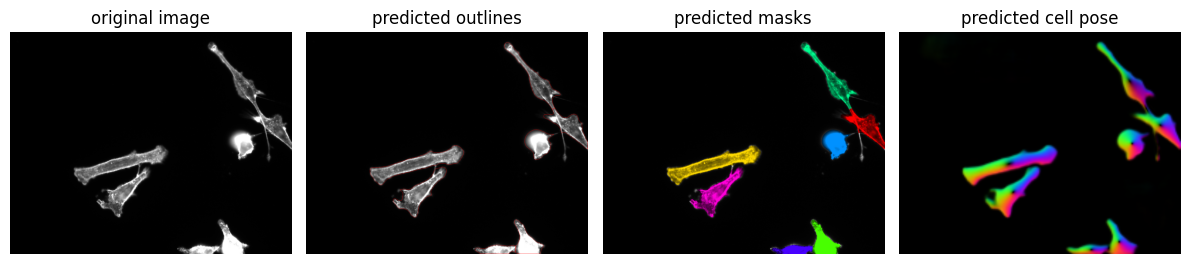

Processing Images:   2%|▌                       | 5/210 [00:09<06:18,  1.85s/it]

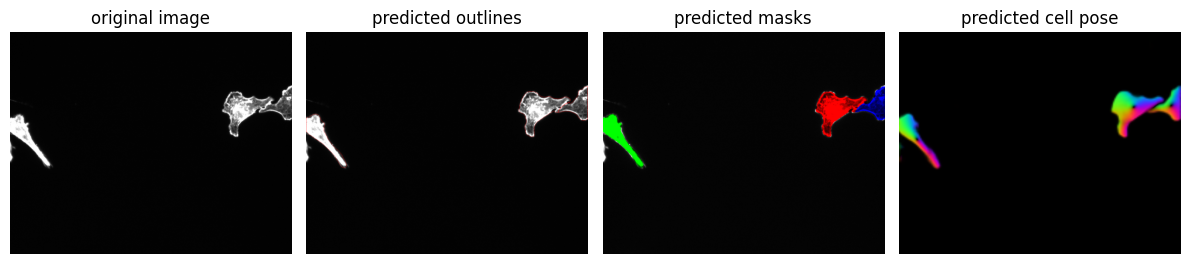

Processing Images:   3%|▋                       | 6/210 [00:14<09:09,  2.70s/it]

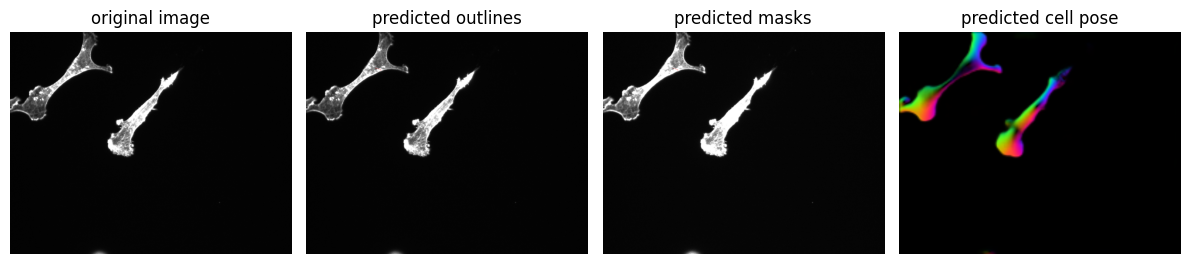

Processing Images:   3%|▊                       | 7/210 [00:21<12:36,  3.73s/it]

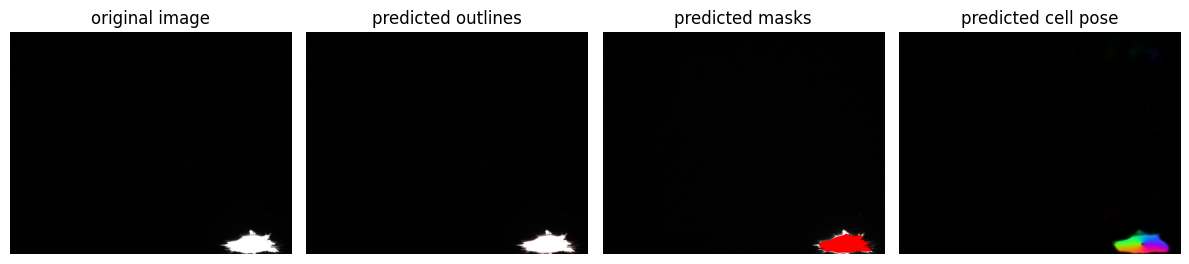

Processing Images:   4%|▉                       | 8/210 [00:25<12:52,  3.82s/it]

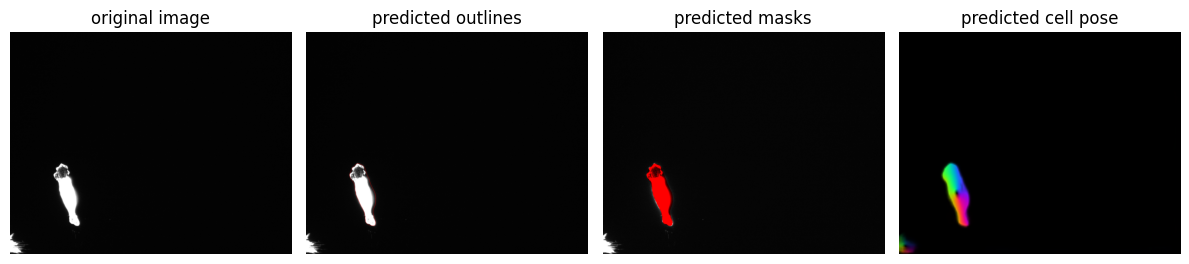

Processing Images:   4%|█                       | 9/210 [00:30<13:29,  4.03s/it]

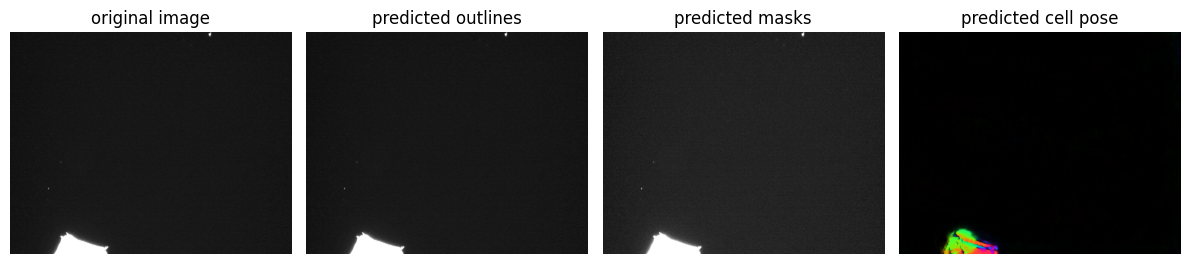

Processing Images:   5%|█                      | 10/210 [00:34<13:44,  4.12s/it]

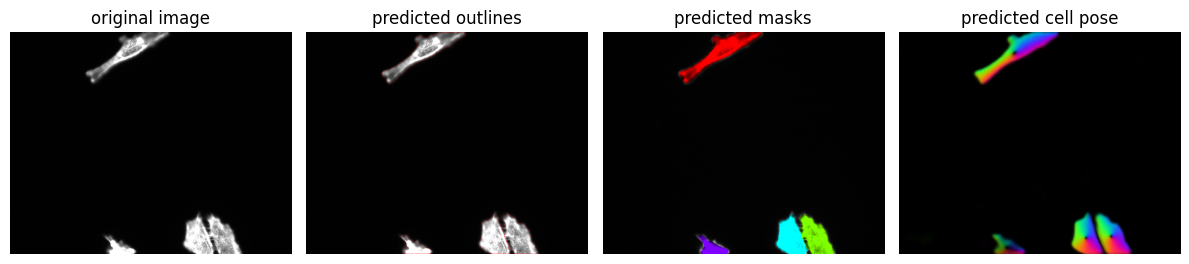

Processing Images:   5%|█▏                     | 11/210 [00:40<14:43,  4.44s/it]

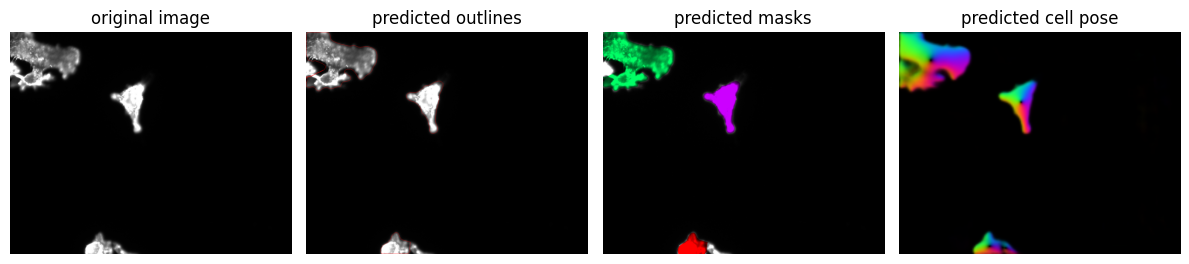

Processing Images:   7%|█▌                     | 14/210 [00:46<10:26,  3.20s/it]

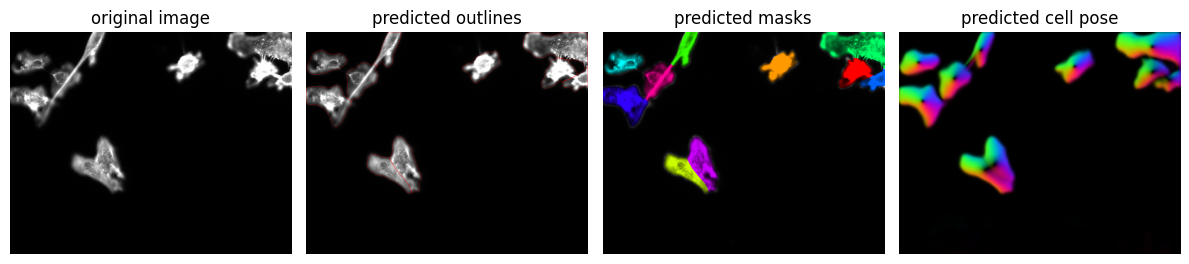

Processing Images:   7%|█▋                     | 15/210 [00:55<14:18,  4.40s/it]

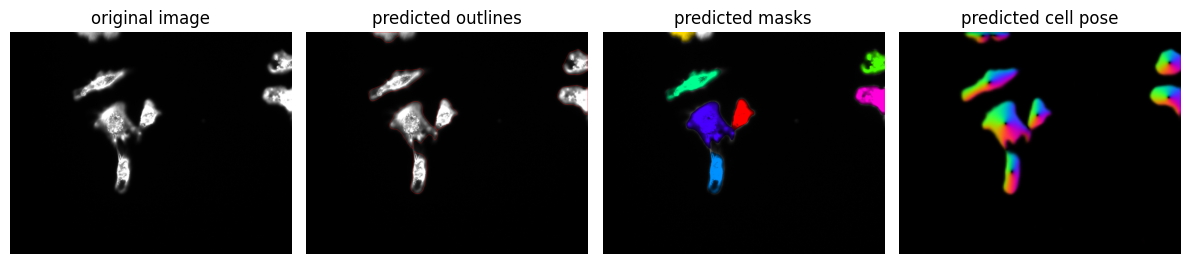

Processing Images:   8%|█▊                     | 17/210 [01:09<13:07,  4.08s/it]


SystemError: CPUDispatcher(<function _extend_centers at 0x7f862e09a310>) returned a result with an error set

<Figure size 1200x500 with 0 Axes>

In [101]:
for name, image in tqdm(image_dict.items(), desc='Processing Images'):
    
    if image.max()<200 or image.mean()<65:
        continue
    fig = plt.figure(figsize=(12,5))
    # Evaluate the image using Cellpose
    model = models.Cellpose(gpu=False, model_type='cyto3')
    masks, flows, diams, _ = model.eval(image, diameter=200, channels=[0, 0])

    plot.show_segmentation(fig, image, masks, flows[0], channels=[0,0])
    plt.tight_layout()
    plt.show()
    

mean: 75.57208509610963 max: 100


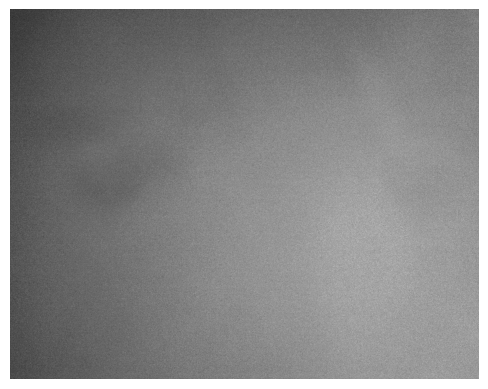

mean: 78.84911089970569 max: 106


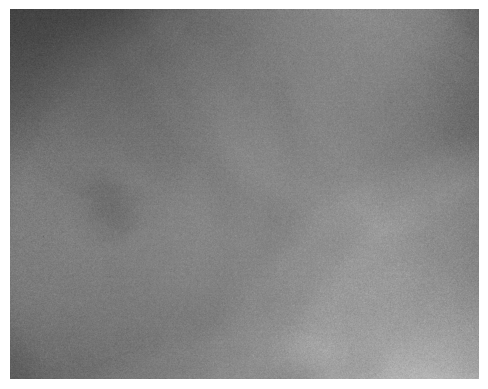

mean: 66.31176638807138 max: 98


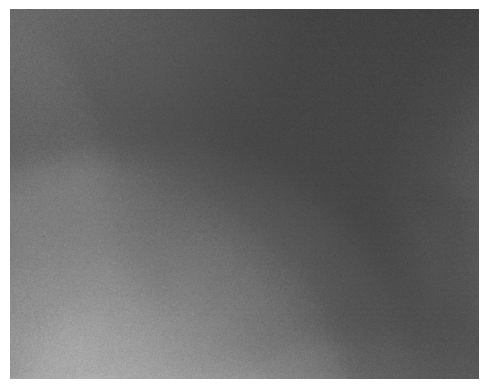

mean: 63.83383294628897 max: 83


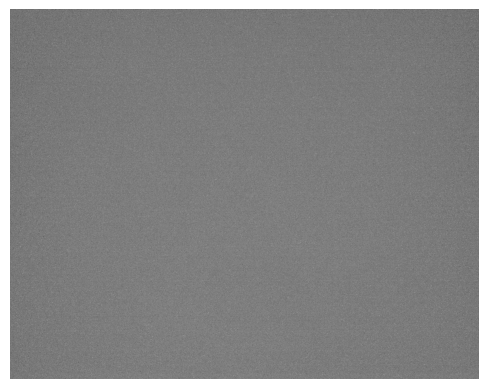

mean: 70.18416030534351 max: 115


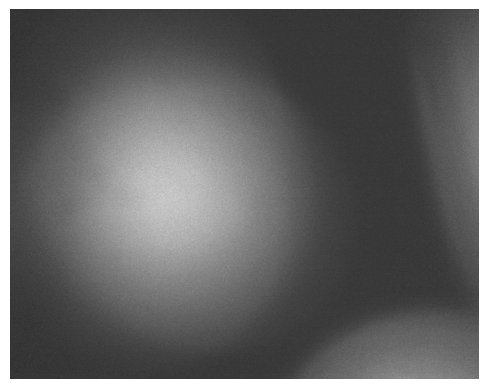

mean: 72.21333089993563 max: 96


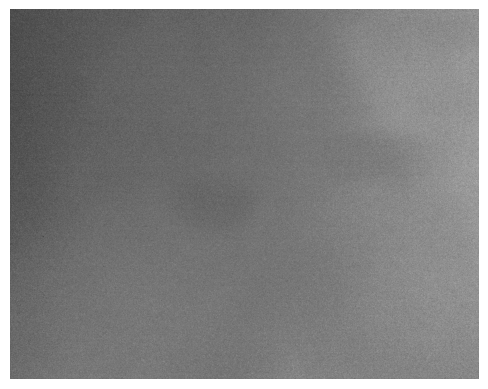

mean: 76.94339691782396 max: 99


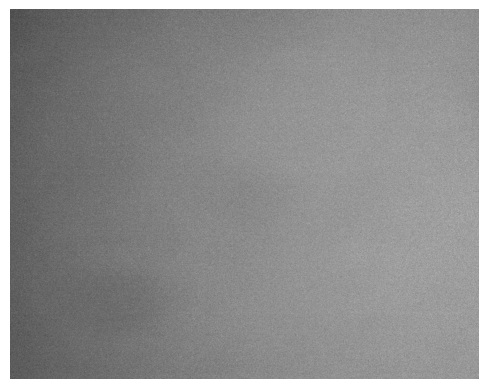

mean: 139.82406965648855 max: 3546


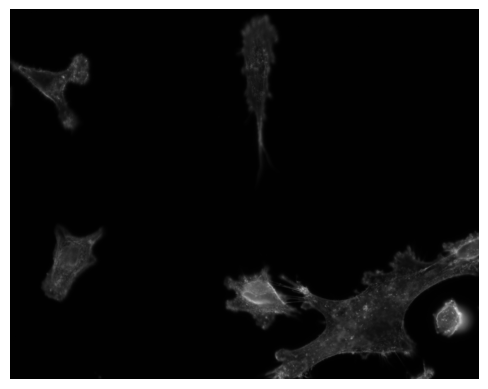

mean: 130.72657255932126 max: 3658


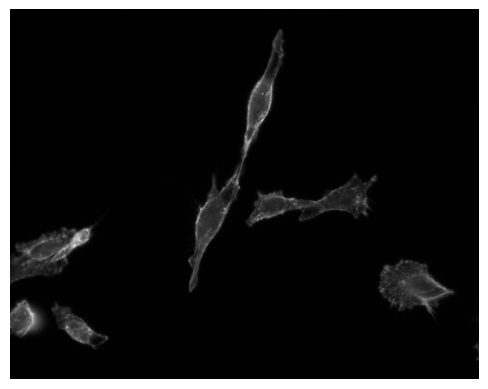

mean: 125.57667789478525 max: 3372


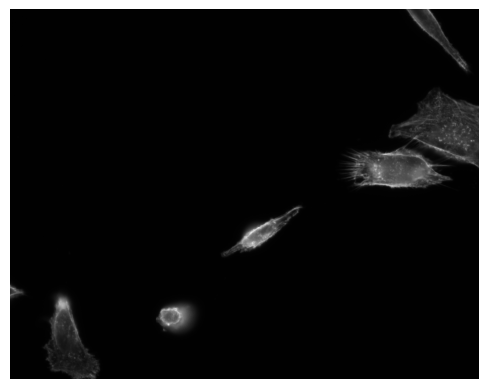

mean: 66.21309450588613 max: 2555


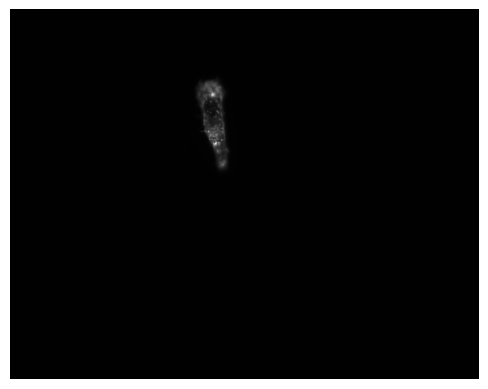

mean: 75.91883708498115 max: 2830


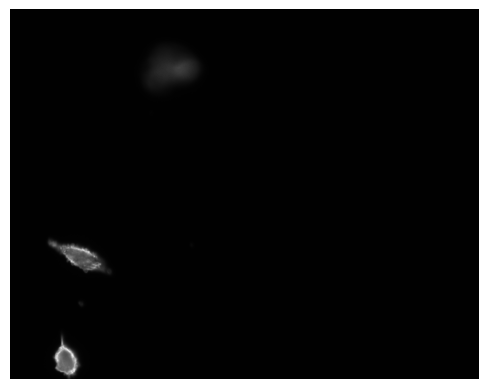

mean: 61.8507232651982 max: 1486


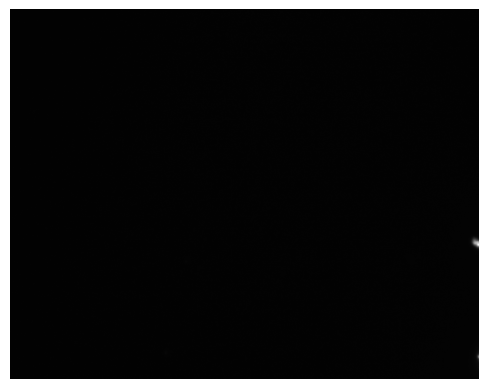

mean: 85.22637783960269 max: 2783


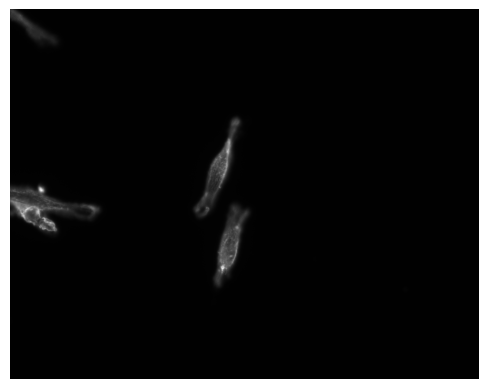

mean: 116.73746393014807 max: 4095


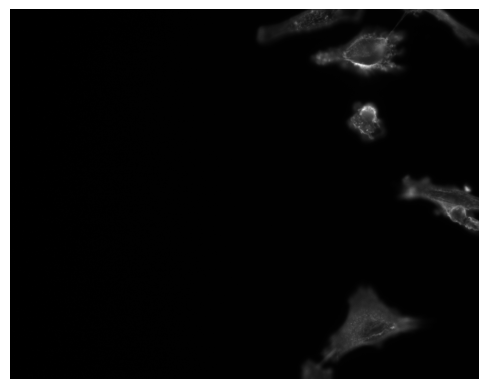

mean: 101.55314770532512 max: 4095


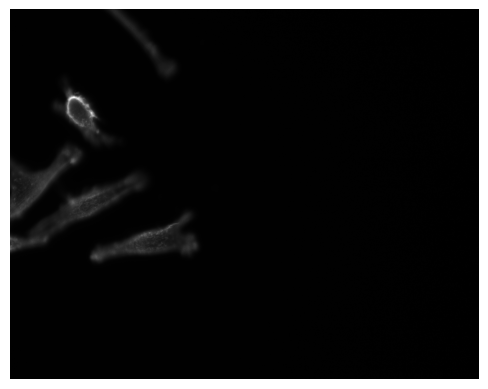

mean: 93.75805751632484 max: 2786


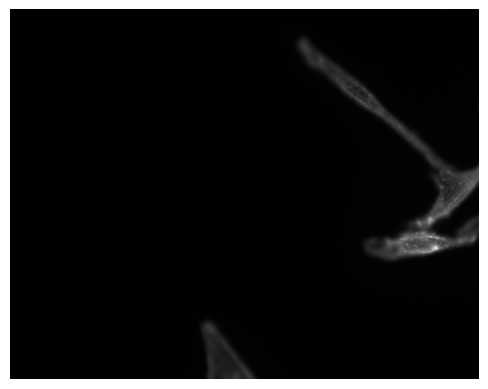

mean: 117.19035253609859 max: 3950


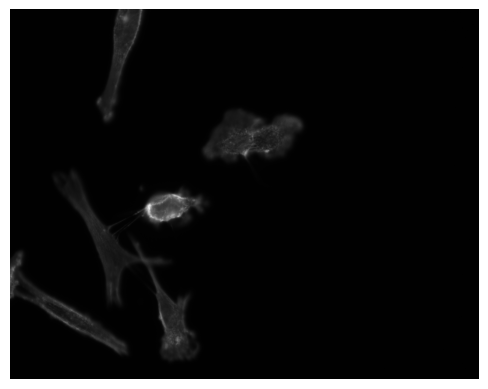

mean: 71.66321464292284 max: 2333


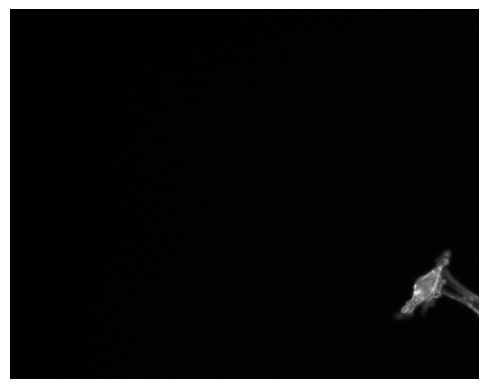

mean: 76.27061945300285 max: 3365


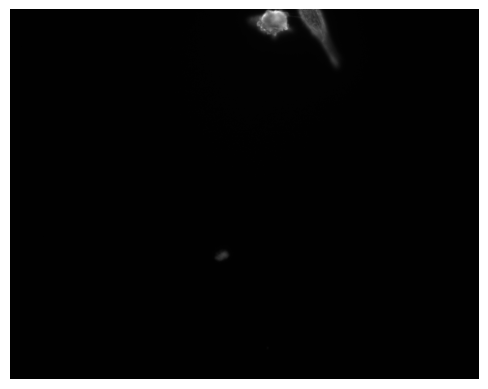

mean: 112.83003914513014 max: 3986


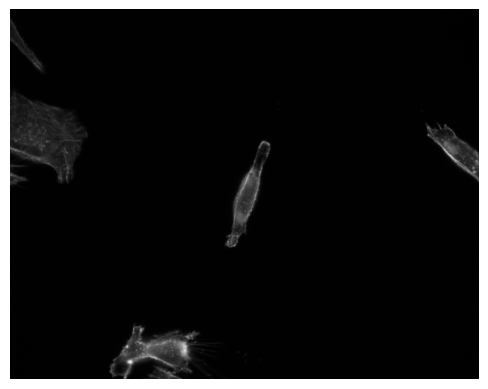

mean: 93.06547612204544 max: 3354


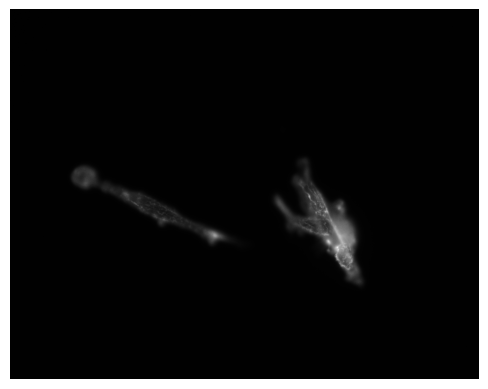

mean: 62.993550538029986 max: 479


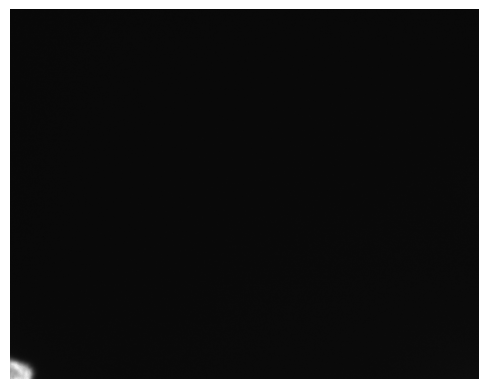

mean: 173.72863974983906 max: 4095


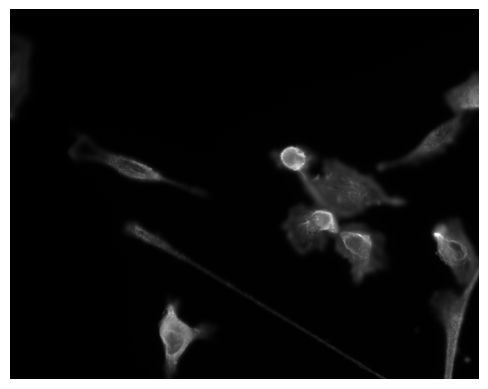

mean: 149.1752412800055 max: 4095


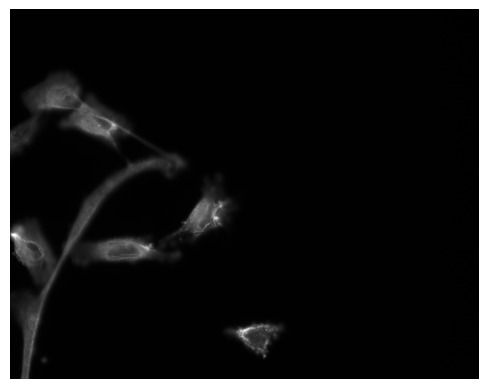

mean: 71.68787938011589 max: 3465


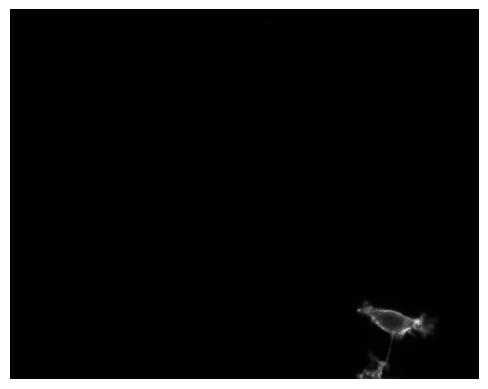

mean: 83.26687882254208 max: 2183


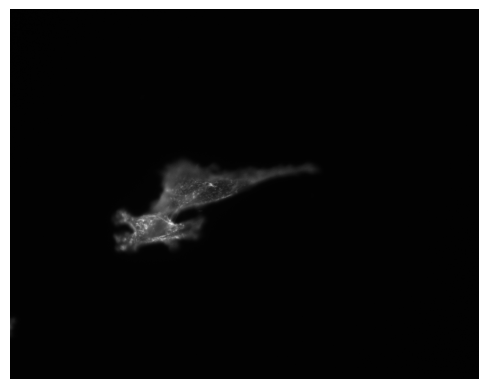

mean: 65.95802820058861 max: 1764


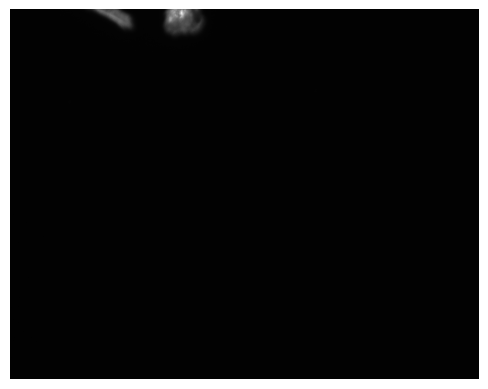

mean: 87.7486951623287 max: 905


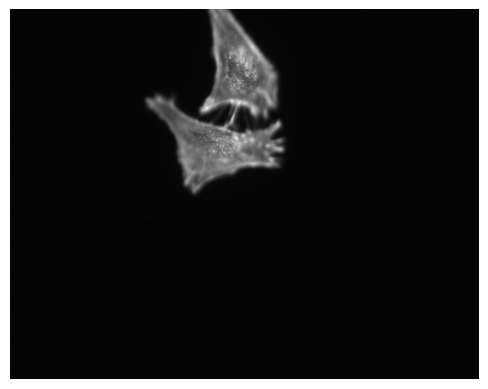

mean: 105.89576028350041 max: 4095


KeyboardInterrupt: 

In [96]:
for key, val in slicy.items():
    print("mean:",val.mean(), "max:",val.max())
    plt.imshow(val, cmap='gray')
    plt.axis('off')
    plt.show()

In [54]:
model = models.Cellpose(gpu=False, model_type='cyto3')

In [102]:
dfs = []
for name, image in tqdm(image_dict.items(), desc='Processing Images'):

    if image.max()<400 or image.mean()<62:
        continue
    # Evaluate the image using Cellpose
    masks, flows, diams, _ = model.eval(image, diameter=200, channels=[0, 0])
    # Label the masks
    labeled_mask = measure.label(masks)
    cleared_mask = segmentation.clear_border(labeled_mask)
    # Calculate region properties
    props = measure.regionprops_table(cleared_mask, intensity_image=image, properties=properties)
    
    # Create a DataFrame for the properties
    df = pd.DataFrame(props)
    
    # Add a column for the filename
    df['image_name'] = name
    
    # Append the dataframe to the list
    dfs.append(df)

# Concatenate all dataframes into a single dataframe
all_props_df = pd.concat(dfs, ignore_index=True)

# Optionally, save the dataframe to a CSV file


Processing Images: 100%|██████████████████████| 210/210 [16:36<00:00,  4.74s/it]


In [103]:
all_props_df = all_props_df[all_props_df['area']>150]
all_props_df.to_csv('/Users/ninagrishencko/Desktop/OlsonLab/Katarina/inhibitor_N2/100_uM_morph_properties.csv', index=False)